## Modeling and Prediction

### Import libraries and load train/test data

In [2]:
#import libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import random

from numpy import arange
from numpy import argmax

In [3]:
train_data=pd.read_csv('../data/train_data.csv')
test_data=pd.read_csv('../data/test_data.csv')

In [5]:
train_data['reordered']=train_data['reordered'].astype(int)

In [140]:
abs((train_data.drop(['user_id','product_id'], axis=1)).corr()[['reordered']]).sort_values(by='reordered', ascending=False)

,reordered
reordered,1.000000
reorder_last5_count,0.386591
order_last5_count,0.386080
reorder_rate_last5,0.297105
user_prd_reorder_ratio,0.281601
user_prd_count,0.248376
prd_reordered_ratio,0.167360
prd_avg_cart_postion,0.129354
prd_count,0.126969
aisle_count,0.103531


### Train/Test/Split by user

Since we predict whether user makes repeat purchase for the products, we split train_data to train and val datasets by user to make sure same users in train or val dataset. 

Split train and val datasets by user

In [7]:
# The correlation rate for user_reordered_ratio is quite low, so we decide to drop it.
X = train_data.drop(['product_id', 'user_reorder_ratio'], axis=1)

In [8]:
train_data.user_id.nunique()

131209

In [9]:
total_users = list(train_data.user_id.unique())

In [10]:
# randomize users
random.shuffle(total_users)

In [11]:
# train test split with test_size=0.25
train_users = total_users[:98406]
test_users  = total_users[98406:]

In [13]:
X_train = X.set_index('user_id').loc[train_users,:]
X_val  = X.set_index('user_id').loc[test_users,:]

In [14]:
y_train = X_train.reordered
y_val = X_val.reordered
X_train = X_train.drop(['reordered'],axis=1)
X_val = X_val.drop(['reordered'],axis=1)

In [16]:
# X_test for prediction.
X_test=test_data.drop(['order_id','user_id', 'product_id', 'user_reorder_ratio'], axis=1)

create X_train_full and y_train_full

In [18]:
X_train_full = train_data.drop(['product_id', 'user_reorder_ratio', 'user_id', 'reordered'], axis=1)

In [20]:
y_train_full = train_data['reordered']

In [21]:
y_train_full.value_counts(normalize=True)

0    0.9022
1    0.0978
Name: reordered, dtype: float64

### Baseline f1 score

Baseline f1 score is calculated referring to 
[this website](https://stats.stackexchange.com/questions/390200/what-is-the-baseline-of-the-f1-score-for-a-binary-classifier)

Our assumption is that predict all as positive, which is 'reordered =1' for our case. 
According to y_train_full data, the probability p(reordered=1)= 0.0978. 

If we assume that predicts all as positive:                                                                             
precision = (true positive)/(total predict positive) = 0.0978                                                           
recall = (true positive)/(total actual positive) = 1                                                                     
So our baseline f1 score is:                                                                                            
f1 score=(2 x precision x recall)/(precision+recall) = (2x 0.0978)/(1+0.0978) = **0.178**

### Evaluation metric and models chosen

In this project, f1 score is used as evaluation metric. F1 score is the harmonic mean of precision and recall. It weights these two equally and is normally use for imbalanced dataset, especially for the case where we have more negative examples that positive examples [[3]](https://stats.stackexchange.com/questions/329102/comparing-f1-score-across-imbalanced-data-sets). In this project, we have imbalanced dataset with positive (reordered =1) and negative (reordered=0) ratio as 9:1 roughly.

This is binary classification problem for this project. So we choose some models to deal with binary classification issue, i.e. logistic regression (basic binary classification model), XGBoost/Lightgbm (Gradient Tree Boosting techniques), Random Forest (Bagging Based techniques).

XGBoost/Lightgbm performs well on imbalanced classification datasets. It offers a way to tune the training algorithm to pay more attention to misclassification of the minority class for datasets with a skewed class distribution[[4]](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

RF is robust to overfitting. Parameterization for random forest remains quite intuitive and straightforward.

### Functions for modelling and prediction

#### Function to get optimal threshold

For those classification problems that have a severe class imbalance, the default threshold (0.5) can result in poor performance. As such, a simple and straightforward approach to improving the performance of a classifier that predicts probabilities on an imbalanced classification problem is to tune the threshold used to map probabilities to class labels.

We use the following functions to get optimal threshold. refers to [this website](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/).

In [22]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [247]:
def optimal_threshold(yhat):
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0, 1, 0.01)
    # evaluate each threshold
    scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
    # save f1 score with threshold by step 0.1 in dict for plotting
    th_dic={}
    for i in range(0, len(thresholds),10):
        th_dic[thresholds[i]]=scores[i]
    # get best threshold
    ix = argmax(scores)
    return thresholds[ix], scores[ix],th_dic

In [25]:
# print f1 score for train and val dataset
def train_val_f1_score(threshold, model):
    y_pred_train=[1 if pred[1]>=threshold else 0 for pred in model.predict_proba(X_train)]
    y_pred_val=[1 if pred[1]>=threshold else 0 for pred in model.predict_proba(X_val)]
    train_f1score=f1_score(y_train,y_pred_train)
    val_f1score=f1_score(y_val,y_pred_val)
    print('f1-score on train data: {}'.format(train_f1score))
    print('f1-score on validate data: {}'.format(val_f1score))
    return train_f1score, val_f1score

#### Function to create submission file

These functions are applied to create the submission file.

In [26]:
def submission(model, ot):
    predictions = model.predict_proba(X_test)
    test_data['reordered']=predictions[:, 1]
    final = test_data[['order_id','product_id','reordered']]
    dic=create_product_list(final, ot)
    dic_join=join_products(dic)
    submission=pd.DataFrame.from_dict(dic_join, orient='index').reset_index()
    submission.columns=['order_id', 'products']
    submission['order_id']=submission['order_id'].astype('int')
    test_data.drop('reordered', axis=1, inplace=True)
    return submission

In [27]:
def create_product_list(df, threshold):
    dic={}
    for index, row in df.iterrows():
        if row.reordered>=threshold:
            dic.setdefault(row.order_id, []).append(int(row.product_id))

    for order in df.order_id:
        if order not in dic:
            dic[order] = 'None'
    return dic

In [28]:
def join_products(dic):
    for key, value in dic.items():
        dic[key]= " ".join(str(item) for item in value)
    return dic

### Modeling

#### Create Results DataFrame

In [125]:
results = pd.DataFrame(columns=['Classifier', 'Hyperparams','Optimal Threshold', 
                                'Train f1 score', 'Val f1 score',
                                'Test f1 score'])

#### Logistic Regression

In [30]:
pipe_lr = Pipeline([
        ('scale', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=200))
    ])

In [31]:
pipe_lr_params = {
    'logreg__C': [0.1, 0.5, 1]
}

In [32]:
grid_pipe_lr = GridSearchCV(pipe_lr, pipe_lr_params, cv=2, verbose=3,n_jobs=-1)

In [33]:
grid_pipe_lr.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=200))]),
             n_jobs=-1, param_grid={'logreg__C': [0.1, 0.5, 1]}, verbose=3)

In [34]:
pipe_lr_bestmodel = grid_pipe_lr.best_estimator_

In [35]:
pipe_lr_bestmodel

Pipeline(steps=[('scale', StandardScaler()),
                ('logreg', LogisticRegression(C=0.1, max_iter=200))])

##### Get the optimal threshold and F1 score

In [36]:
preds_val_lr_pipe = pipe_lr_bestmodel.predict_proba(X_val)

In [248]:
ot_lr, f1_lr, th_dic_lr= optimal_threshold(preds_val_lr_pipe)

In [232]:
# the optimal threshold for logistic regression is 0.2 with maximum f1 score as 0.429
ot_lr,f1_lr

(0.2, 0.42871514208120814)

plot threshold vs. f1 socre

The plot about threshold vs. f1 score shows that when threshold is around 0.2, we have maximum f1 score for logistic regression.

In [249]:
lr_th_f1=pd.DataFrame.from_dict(th_dic_lr, orient='index', columns=['f1 score'])

In [250]:
lr_th_f1=lr_th_f1.reset_index()

In [251]:
lr_th_f1.columns=['threshold','f1 score']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


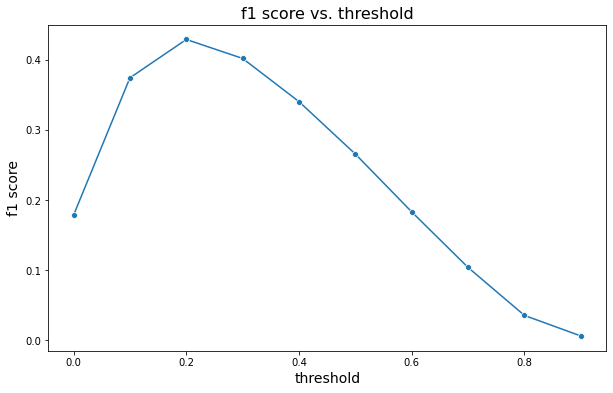

In [252]:
plt.figure(figsize=(10,6))
sns.lineplot(lr_th_f1['threshold'], lr_th_f1['f1 score'],marker='o')
plt.title('f1 score vs. threshold', size=16)
plt.xlabel('threshold', size=14)
plt.ylabel('f1 score', size=14);

In [39]:
# print f1 score for train and val data with optimal threshold
lr_train_f1, lr_val_f1 = train_val_f1_score(ot_lr, pipe_lr_bestmodel)

f1-score on train data: 0.42673495214306245
f1-score on validate data: 0.42871514208120814


##### Prediction and kaggle submission

In [40]:
# train model with whole train dataset before prediction
pred_model = pipe_lr_bestmodel.fit(X_train_full, y_train_full)

In [41]:
# create submission dataframe
submission_df = submission(pred_model, ot_lr)

In [42]:
# save kaggle submission file as .csv file
submission_df.to_csv('../submission/submission_lr.csv', index=False)

kaggle score: 0.36261

In [126]:
results = results.append(
    {'Classifier': 'Logistic Regression', 
     'Hyperparams': grid_pipe_lr.best_params_,
     'Optimal Threshold': ot_lr,
     'Train f1 score': round(lr_train_f1, 3), 
     'Val f1 score': round(lr_val_f1, 3),
    'Test f1 score': round(0.36261, 3)},
    ignore_index=True)

#### XGBoost

In [45]:
xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')

In [48]:
xgbc_params = {'max_depth':[3,5,6],
               'n_estimators':[500,1000,1200],
               'learning_rate':[0.02, 0.05, 0.1]          
            } 

In [49]:
grid_xgbc = GridSearchCV(xgbc, xgbc_params, cv=2, verbose=3, n_jobs=-1)

In [50]:
grid_xgbc.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='error',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=No

In [51]:
xgbc_best_model = grid_xgbc.best_estimator_

In [52]:
grid_xgbc.best_params_

{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 1000}

##### Get the optimal threshold and F1 score

In [53]:
preds_val_xgbc = xgbc_best_model.predict_proba(X_val)

In [253]:
ot_xgbc, f1_xgbc, th_dic_xgbc= optimal_threshold(preds_val_xgbc)

In [55]:
# the optimal threshold for XGBoost is 0.21 with maximum f1 score as 0.433
ot_xgbc, f1_xgbc

(0.21, 0.43291098317645454)

plot threshold vs. f1 socre

The plot about threshold vs. f1 score shows that when threshold is around 0.2, we have maximum f1 score for XGBoost.

In [254]:
xgbc_th_f1=pd.DataFrame.from_dict(th_dic_xgbc, orient='index', columns=['f1 score'])

In [255]:
xgbc_th_f1=xgbc_th_f1.reset_index()

In [256]:
xgbc_th_f1.columns=['threshold','f1 score']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


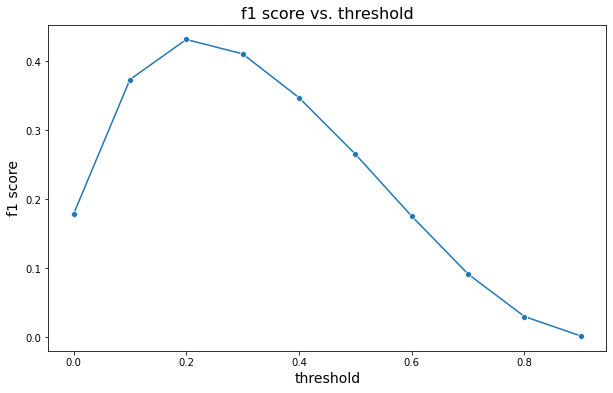

In [257]:
plt.figure(figsize=(10,6))
sns.lineplot(xgbc_th_f1['threshold'], xgbc_th_f1['f1 score'],marker='o')
plt.title('f1 score vs. threshold', size=16)
plt.xlabel('threshold', size=14)
plt.ylabel('f1 score', size=14);

In [56]:
# with optimal threshold
xgbc_train_f1, xgbc_val_f1 = train_val_f1_score(ot_xgbc, xgbc_best_model)

f1-score on train data: 0.4338459620100586
f1-score on validate data: 0.43291098317645454


##### prediction and kaggle submission

In [57]:
pred_model = xgbc_best_model.fit(X_train_full, y_train_full)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [59]:
xgbc_submission = submission(pred_model, ot_xgbc)

In [60]:
xgbc_submission.to_csv('../submission/submission_xgbc.csv', index=False)

kaggle score: 0.36466

In [128]:
results = results.append(
    {'Classifier': 'XGBoost', 
     'Hyperparams': grid_xgbc.best_params_, 
     'Optimal Threshold': ot_xgbc,
     'Train f1 score': round(xgbc_train_f1, 3), 
     'Val f1 score': round(xgbc_val_f1, 3),
    'Test f1 score': round(0.36466, 3)},
    ignore_index=True)

#### Lightgbm 

In [80]:
lgbm=lgb.LGBMClassifier(objective='binary')

In [81]:
lgbm_params = {'max_depth':[3, 5,8],
               'learning_rate':[0.02, 0.05, 0.1],
               'num_iterations':[500,1000],             
              } 

In [82]:
grid_lgbm = GridSearchCV(lgbm, lgbm_params, cv=2, verbose=3, n_jobs=-1)

In [83]:
grid_lgbm.fit(X_train,y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv=2, estimator=LGBMClassifier(objective='binary'), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [3, 5, 8],
                         'num_iterations': [500, 1000]},
             verbose=3)

In [84]:
grid_lgbm.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'num_iterations': 500}

In [85]:
lgbm_best_model=grid_lgbm.best_estimator_

##### Get the optimal threshold and F1 score

In [87]:
preds_val_lgbm=lgbm_best_model.predict_proba(X_val)

In [258]:
ot_lgbm, f1_lgbm, th_dic_lgbm=optimal_threshold(preds_val_lgbm)

In [89]:
# The optomal threshold for Lightgbm is 0.22 with maximum f1 score as 0.432
ot_lgbm, f1_lgbm

(0.22, 0.4321678381917166)

plot threshold vs. f1 socre

The plot about threshold vs. f1 score shows that when threshold is around 0.2, we have maximum f1 score for Lightgbm.

In [259]:
lgbm_th_f1=pd.DataFrame.from_dict(th_dic_lgbm, orient='index', columns=['f1 score'])

In [260]:
lgbm_th_f1=lgbm_th_f1.reset_index()

In [261]:
lgbm_th_f1.columns=['threshold','f1 score']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


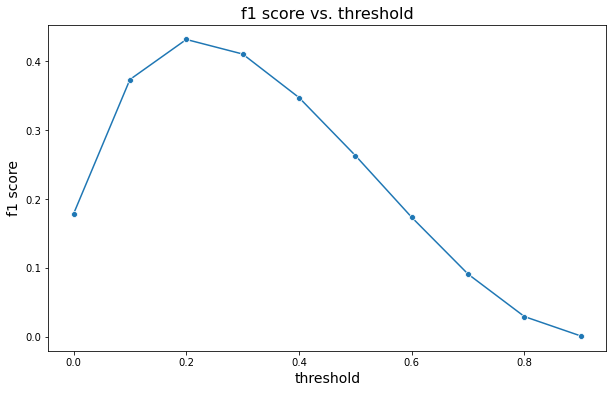

In [262]:
plt.figure(figsize=(10,6))
sns.lineplot(lgbm_th_f1['threshold'], lgbm_th_f1['f1 score'],marker='o')
plt.title('f1 score vs. threshold', size=16)
plt.xlabel('threshold', size=14)
plt.ylabel('f1 score', size=14);

In [90]:
lgbm_train_f1, lgbm_val_f1 = train_val_f1_score(ot_lgbm, lgbm_best_model)

f1-score on train data: 0.4309935974294663
f1-score on validate data: 0.4321678381917166


##### prediction and kaggle submission

In [91]:
pred_lgbm_model = lgbm_best_model.fit(X_train_full, y_train_full)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [92]:
y_pred_fulltrain=[1 if pred[1]>=ot_lgbm else 0 for pred in pred_lgbm_model.predict_proba(X_train_full)]
print('f1-score on full train data: {}'.format(f1_score(y_train_full,y_pred_fulltrain)))

f1-score on full train data: 0.4313568423517632


In [93]:
lgbm_submission = submission(pred_lgbm_model, ot_lgbm)

In [94]:
lgbm_submission.to_csv('../submission/submission_lgbm.csv', index=False)

kaggle score: 0.36479

In [130]:
results = results.append(
    {'Classifier': 'Lightgbm', 
     'Hyperparams': grid_lgbm.best_params_, 
     'Optimal Threshold': ot_lgbm,
     'Train f1 score': round(lgbm_train_f1, 3), 
     'Val f1 score': round(lgbm_val_f1, 3),
    'Test f1 score': round(0.36479, 3)},
    ignore_index=True)

#### Random Forest

In [97]:
rfc=RandomForestClassifier()

In [98]:
rfc_params = {'max_depth':[15,12,10,8,5],
               'n_estimators':[100,250,500,750,1000],               
              } 

In [99]:
grid_rfc = GridSearchCV(rfc, rfc_params, cv=2, verbose=3, n_jobs=-1)

In [100]:
grid_rfc.fit(X_train,y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 12, 10, 8, 5],
                         'n_estimators': [100, 250, 500, 750, 1000]},
             verbose=3)

In [101]:
rfc_best_model=grid_rfc.best_estimator_

In [102]:
grid_rfc.best_params_

{'max_depth': 12, 'n_estimators': 1000}

##### Get the optimal threshold and F1 score

In [104]:
preds_val_rfc=rfc_best_model.predict_proba(X_val)

In [263]:
ot_rfc, f1_rfc, th_dic_rfc=optimal_threshold(preds_val_rfc)

In [106]:
# the optimal threshold for random forest classifier is 0.21 with maximum f1 score as 0.431.
ot_rfc, f1_rfc

(0.21, 0.4313631102748657)

plot threshold vs. f1 socre

The plot about threshold vs. f1 score shows that when threshold is around 0.2, we have maximum f1 score for random forest.

In [264]:
rfc_th_f1=pd.DataFrame.from_dict(th_dic_rfc, orient='index', columns=['f1 score'])

In [265]:
rfc_th_f1=rfc_th_f1.reset_index()

In [266]:
rfc_th_f1.columns=['threshold','f1 score']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


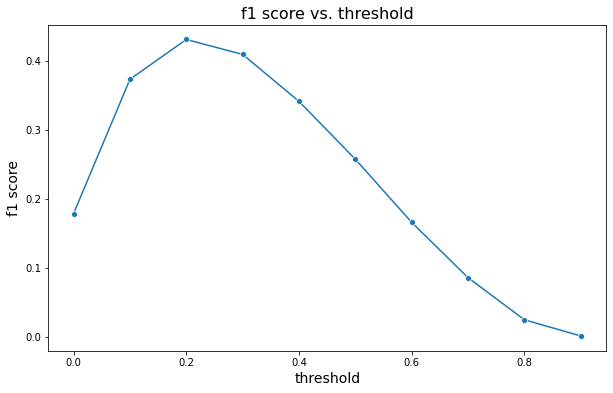

In [267]:
plt.figure(figsize=(10,6))
sns.lineplot(rfc_th_f1['threshold'], rfc_th_f1['f1 score'],marker='o')
plt.title('f1 score vs. threshold', size=16)
plt.xlabel('threshold', size=14)
plt.ylabel('f1 score', size=14);

In [107]:
rfc_train_f1, rfc_val_f1 = train_val_f1_score(ot_rfc, rfc_best_model)

f1-score on train data: 0.4365175780744583
f1-score on validate data: 0.4313631102748657


##### prediction and kaggle submission 

In [108]:
pred_rfc_model = rfc_best_model.fit(X_train_full, y_train_full)

In [110]:
rfc_submission = submission(pred_rfc_model, ot_rfc)

In [111]:
rfc_submission.to_csv('../submission/submission_rfc.csv', index=False)

kaggle score: 0.36755

In [132]:
results = results.append(
    {'Classifier': 'Random Forest', 
     'Hyperparams': grid_rfc.best_params_,
     'Optimal Threshold': ot_rfc,
     'Train f1 score': round(rfc_train_f1, 3), 
     'Val f1 score': round(rfc_val_f1, 3),
    'Test f1 score': round(0.36755, 3)},
    ignore_index=True)

### Model Comparison

In [ ]:
#results

| Classifier          | Hyperparams                                                                                                                                   | Optimal Threshold |   Train f1 score |   Val f1 score |   Test f1 score |
|:--------------------|:----------------------------------------------------------------------------------------------------------------------------------------------|:----------------|--------------:|---------------:|---------------:|
| Logistic Regression | {'logreg__C': 0.1}                                                           |            0.20 |          0.427 |           0.429  |0.363|
| XGBoost            | {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 1000}                     |            0.21 |          0.434 |           0.433 |0.365|
| Lightgbm                 | {'learning_rate': 0.1, 'max_depth': 3, 'num_iterations': 500}                    |            0.22  |          0.431 |           0.432 |0.365|
| Random Forest       | {'max_depth': 12, 'n_estimators': 1000} |            0.21 |          0.437 |           0.431 |0.368|

Comparing the performance on the test data versus the performance on the training data, we do observe some overfitting. 

We can observe that amongst these models, random forest performances best. However, due to large dataset, it requests quite long time to train random forest model. The second best performance models are boost models, i.e. XGBoost and Lightgbm. They requires shorter time to train, especially Lightgbm model needs even shorter time than XGBoost. Not surprisedly, the third best performance model is Logistic Regression due to its naive nature.

The performance gap between Random Forest & Logistic Regression is not that much. If we would like to obtain rough result quickly, we can apply logistic regression model. 

### Analyse Best Model Coefficients

Text(0.5, 1.0, 'Feature Importance')

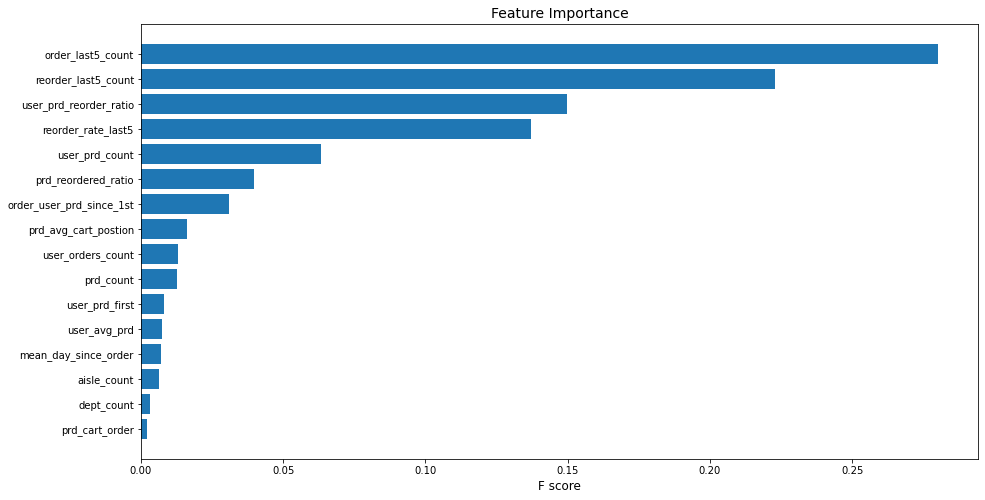

In [135]:
plt.figure(figsize=(15,8))
sorted_idx = rfc_best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rfc_best_model.feature_importances_[sorted_idx])
plt.xlabel('F score', size=12)
plt.title('Feature Importance', size=14)

Last5 orders and user_product related features are the strongest features. If customer bought products frequently during latest orders, he/she would have a preference for these products during that period of time and may tend to buy again in next purchase. User_prodcut features indicates customers' long term preference of some products. For example, customer may prefer certain brands or may prefer certain type of products, i.e. organic food. Thus, customer will also tend to purchase these products repeatedly.

## Conclusion and Recommendations

In conclusion, we believe that our model can predict product reorder in next purchase effectively, with f1 score as 0.368. The prediction result can help increase sales and improve customer retention rate for Instacart. We suggest Instacart to utilize of data science to understand customers' short term and long term preference. For example, through customer latest orders, we can understand customers' recent preference. We also can understand customers' long term preference through more historical order data. 

As mentioned in previous section, customer retention rate is important to Instacart. 
With prediction results from our model, we can provide the following recommendations to improve customer retention rate. 
1. Offer personalized discounts and credits on products that customers may purchase repeatedly in their next orders.
2. Send engaging emails to customers based on the prediction result for repeating purchase.

## References

1. https://en.wikipedia.org/wiki/Instacart
2. https://www.lightspeedhq.com/blog/customer-retention-rate/
3. https://stats.stackexchange.com/questions/329102/comparing-f1-score-across-imbalanced-data-sets
4. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
5. https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
6. https://stats.stackexchange.com/questions/390200/what-is-the-baseline-of-the-f1-score-for-a-binary-classifier